# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [6]:
from __future__ import absolute_import, division, print_function

In [7]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [27]:
import nltk
import gensim.models.word2vec as w2v
import multiprocessing
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\D072202\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Set up logging**

In [29]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [30]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\D072202\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\D072202\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("data/clean/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


[]

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/clean/asoiaf01.txt'...
Corpus is now 1621319 characters long

Reading 'data/clean/asoiaf02.txt'...
Corpus is now 3422095 characters long

Reading 'data/clean/asoiaf03.txt'...
Corpus is now 5762653 characters long

Reading 'data/clean/asoiaf04.txt'...
Corpus is now 7508746 characters long

Reading 'data/clean/asoiaf05.txt'...
Corpus is now 9869711 characters long



**Split the corpus into sentences**

In [11]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [40]:
f = open('C:/Users/D072202/Desktop/triples.csv','r', encoding="UTF-8")
x = f.read()
raw_sentences = re.split("\n",x)
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    words = raw.split(" ")
    return words
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [51]:
print(raw_sentences[2])
print(sentence_to_wordlist(raw_sentences[2]))
print(sentences[5])

<web/nameplate_siw_144_a_ul_service_assy__repair_part_> <web/property/productspid> 3906950
['<web/nameplate_siw_144_a_ul_service_assy__repair_part_>', '<web/property/productspid>', '3906950']
['<web/b_36_6_0_li_ion>', '<web/property/productsname>', 'b', '36', '60', 'li-ion']


In [52]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 68,272 tokens


## Train Word2Vec

In [53]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [54]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)
thrones2vec.build_vocab(sentences)
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=1000)

In [55]:
thrones2vec.build_vocab(sentences)

2019-03-25 12:52:30,820 : INFO : collecting all words and their counts
2019-03-25 12:52:30,822 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-25 12:52:30,848 : INFO : PROGRESS: at sentence #10000, processed 46038 words, keeping 6378 word types
2019-03-25 12:52:30,858 : INFO : collected 7484 word types from a corpus of 68272 raw words and 14766 sentences
2019-03-25 12:52:30,859 : INFO : Loading a fresh vocabulary
2019-03-25 12:52:30,872 : INFO : effective_min_count=3 retains 3821 unique words (51% of original 7484, drops 3663)
2019-03-25 12:52:30,873 : INFO : effective_min_count=3 leaves 64083 word corpus (93% of original 68272, drops 4189)
2019-03-25 12:52:30,892 : INFO : deleting the raw counts dictionary of 7484 items
2019-03-25 12:52:30,894 : INFO : sample=0.001 downsamples 35 most-common words
2019-03-25 12:52:30,895 : INFO : downsampling leaves estimated 45474 word corpus (71.0% of prior 64083)
2019-03-25 12:52:30,920 : INFO : estimated required

In [58]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 3821


**Start training, this might take a minute or two...**

In [62]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=1000)

2019-03-25 12:53:46,133 : INFO : training model with 4 workers on 3821 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-03-25 12:53:46,304 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:46,333 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:46,366 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:46,370 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:46,372 : INFO : EPOCH - 1 : training on 68272 raw words (45402 effective words) took 0.2s, 207570 effective words/s
2019-03-25 12:53:46,515 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:46,583 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:46,588 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:46,590 : INFO : worker thread finished; awaiting finish of 0 mor

2019-03-25 12:53:49,922 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:49,966 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:49,990 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:49,998 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:50,000 : INFO : EPOCH - 17 : training on 68272 raw words (45443 effective words) took 0.2s, 248280 effective words/s
2019-03-25 12:53:50,117 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:50,166 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:50,195 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:50,199 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:50,200 : INFO : EPOCH - 18 : training on 68272 raw words (45584 effective words) took 0.2s, 247477 effective words/s
2019

2019-03-25 12:53:53,409 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:53,411 : INFO : EPOCH - 33 : training on 68272 raw words (45442 effective words) took 0.2s, 250544 effective words/s
2019-03-25 12:53:53,531 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:53,581 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:53,593 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:53,595 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:53,596 : INFO : EPOCH - 34 : training on 68272 raw words (45457 effective words) took 0.2s, 283043 effective words/s
2019-03-25 12:53:53,724 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:53,765 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:53,787 : INFO : worker thread finished; awaiting finish of 1 more threads
2019

2019-03-25 12:53:56,805 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:56,837 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:56,864 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:56,866 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:56,868 : INFO : EPOCH - 50 : training on 68272 raw words (45572 effective words) took 0.2s, 256715 effective words/s
2019-03-25 12:53:56,973 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:53:57,014 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:53:57,037 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:57,040 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:57,042 : INFO : EPOCH - 51 : training on 68272 raw words (45474 effective words) took 0.2s, 283176 effective words/s
2019

2019-03-25 12:53:59,847 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:53:59,853 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:53:59,854 : INFO : EPOCH - 66 : training on 68272 raw words (45298 effective words) took 0.2s, 254027 effective words/s
2019-03-25 12:53:59,983 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:00,040 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:00,042 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:00,048 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:00,050 : INFO : EPOCH - 67 : training on 68272 raw words (45429 effective words) took 0.2s, 265436 effective words/s
2019-03-25 12:54:00,158 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:00,203 : INFO : worker thread finished; awaiting finish of 2 more threads
2019

2019-03-25 12:54:02,963 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:03,004 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:03,035 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:03,038 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:03,039 : INFO : EPOCH - 83 : training on 68272 raw words (45545 effective words) took 0.2s, 276344 effective words/s
2019-03-25 12:54:03,146 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:03,192 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:03,206 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:03,208 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:03,209 : INFO : EPOCH - 84 : training on 68272 raw words (45539 effective words) took 0.2s, 286374 effective words/s
2019

2019-03-25 12:54:06,156 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:06,158 : INFO : EPOCH - 99 : training on 68272 raw words (45448 effective words) took 0.2s, 246307 effective words/s
2019-03-25 12:54:06,274 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:06,313 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:06,331 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:06,337 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:06,338 : INFO : EPOCH - 100 : training on 68272 raw words (45509 effective words) took 0.2s, 276383 effective words/s
2019-03-25 12:54:06,446 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:06,481 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:06,520 : INFO : worker thread finished; awaiting finish of 1 more threads
201

2019-03-25 12:54:09,488 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:09,542 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:09,544 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:09,556 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:09,558 : INFO : EPOCH - 116 : training on 68272 raw words (45567 effective words) took 0.2s, 266439 effective words/s
2019-03-25 12:54:09,684 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:09,732 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:09,737 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:09,743 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:09,744 : INFO : EPOCH - 117 : training on 68272 raw words (45537 effective words) took 0.2s, 274353 effective words/s
20

2019-03-25 12:54:12,761 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:12,764 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:12,765 : INFO : EPOCH - 132 : training on 68272 raw words (45392 effective words) took 0.2s, 248551 effective words/s
2019-03-25 12:54:12,900 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:12,920 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:12,942 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:12,957 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:12,959 : INFO : EPOCH - 133 : training on 68272 raw words (45367 effective words) took 0.2s, 270460 effective words/s
2019-03-25 12:54:13,084 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:13,116 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:54:16,221 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:16,252 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:16,275 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:16,278 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:16,279 : INFO : EPOCH - 149 : training on 68272 raw words (45394 effective words) took 0.2s, 270140 effective words/s
2019-03-25 12:54:16,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:16,460 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:16,467 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:16,479 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:16,482 : INFO : EPOCH - 150 : training on 68272 raw words (45436 effective words) took 0.2s, 243106 effective words/s
20

2019-03-25 12:54:19,589 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:19,592 : INFO : EPOCH - 165 : training on 68272 raw words (45549 effective words) took 0.2s, 225874 effective words/s
2019-03-25 12:54:19,737 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:19,791 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:19,805 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:19,808 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:19,810 : INFO : EPOCH - 166 : training on 68272 raw words (45436 effective words) took 0.2s, 222464 effective words/s
2019-03-25 12:54:19,953 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:19,969 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:19,990 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:54:22,723 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:22,771 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:22,791 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:22,799 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:22,801 : INFO : EPOCH - 182 : training on 68272 raw words (45492 effective words) took 0.2s, 256091 effective words/s
2019-03-25 12:54:22,923 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:22,962 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:22,975 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:22,981 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:22,984 : INFO : EPOCH - 183 : training on 68272 raw words (45379 effective words) took 0.2s, 277773 effective words/s
20

2019-03-25 12:54:26,112 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:26,115 : INFO : EPOCH - 198 : training on 68272 raw words (45474 effective words) took 0.2s, 228053 effective words/s
2019-03-25 12:54:26,242 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:26,293 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:26,320 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:26,331 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:26,334 : INFO : EPOCH - 199 : training on 68272 raw words (45362 effective words) took 0.2s, 218837 effective words/s
2019-03-25 12:54:26,505 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:26,542 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:26,573 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:54:29,544 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:29,601 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:29,631 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:29,636 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:29,639 : INFO : EPOCH - 215 : training on 68272 raw words (45455 effective words) took 0.2s, 236601 effective words/s
2019-03-25 12:54:29,776 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:29,826 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:29,851 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:29,853 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:29,854 : INFO : EPOCH - 216 : training on 68272 raw words (45440 effective words) took 0.2s, 228663 effective words/s
20

2019-03-25 12:54:32,746 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:32,756 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:32,758 : INFO : EPOCH - 231 : training on 68272 raw words (45578 effective words) took 0.2s, 247545 effective words/s
2019-03-25 12:54:32,895 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:32,941 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:32,960 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:32,968 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:32,970 : INFO : EPOCH - 232 : training on 68272 raw words (45486 effective words) took 0.2s, 227900 effective words/s
2019-03-25 12:54:33,155 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:33,221 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:54:36,347 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:36,395 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:36,416 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:36,421 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:36,424 : INFO : EPOCH - 248 : training on 68272 raw words (45536 effective words) took 0.2s, 184673 effective words/s
2019-03-25 12:54:36,574 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:36,629 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:36,656 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:36,660 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:36,661 : INFO : EPOCH - 249 : training on 68272 raw words (45506 effective words) took 0.2s, 208338 effective words/s
20

2019-03-25 12:54:39,982 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:39,985 : INFO : EPOCH - 264 : training on 68272 raw words (45481 effective words) took 0.2s, 235537 effective words/s
2019-03-25 12:54:40,119 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:40,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:40,183 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:40,191 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:40,194 : INFO : EPOCH - 265 : training on 68272 raw words (45532 effective words) took 0.2s, 232090 effective words/s
2019-03-25 12:54:40,337 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:40,354 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:40,388 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:54:43,778 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:43,813 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:43,860 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:43,866 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:43,869 : INFO : EPOCH - 281 : training on 68272 raw words (45473 effective words) took 0.3s, 164666 effective words/s
2019-03-25 12:54:44,005 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:44,031 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:44,049 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:44,063 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:44,065 : INFO : EPOCH - 282 : training on 68272 raw words (45480 effective words) took 0.2s, 248847 effective words/s
20

2019-03-25 12:54:47,256 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:47,258 : INFO : EPOCH - 297 : training on 68272 raw words (45511 effective words) took 0.2s, 233495 effective words/s
2019-03-25 12:54:47,390 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:47,430 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:47,462 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:47,464 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:47,466 : INFO : EPOCH - 298 : training on 68272 raw words (45569 effective words) took 0.2s, 248287 effective words/s
2019-03-25 12:54:47,606 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:47,630 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:47,666 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:54:50,723 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:50,786 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:50,798 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:50,809 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:50,811 : INFO : EPOCH - 314 : training on 68272 raw words (45497 effective words) took 0.2s, 193629 effective words/s
2019-03-25 12:54:50,926 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:50,969 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:50,988 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:50,994 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:50,995 : INFO : EPOCH - 315 : training on 68272 raw words (45386 effective words) took 0.2s, 270672 effective words/s
20

2019-03-25 12:54:54,198 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:54,207 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:54,209 : INFO : EPOCH - 330 : training on 68272 raw words (45610 effective words) took 0.2s, 246230 effective words/s
2019-03-25 12:54:54,327 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:54,369 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:54,387 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:54,389 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:54,390 : INFO : EPOCH - 331 : training on 68272 raw words (45412 effective words) took 0.2s, 267063 effective words/s
2019-03-25 12:54:54,513 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:54,560 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:54:58,738 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:58,791 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:58,809 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:58,812 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:58,812 : INFO : EPOCH - 347 : training on 68272 raw words (45339 effective words) took 0.2s, 194428 effective words/s
2019-03-25 12:54:58,989 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:54:59,040 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:54:59,056 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:54:59,063 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:54:59,064 : INFO : EPOCH - 348 : training on 68272 raw words (45425 effective words) took 0.2s, 193773 effective words/s
20

2019-03-25 12:55:03,283 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:03,283 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:03,283 : INFO : EPOCH - 363 : training on 68272 raw words (45454 effective words) took 0.2s, 233515 effective words/s
2019-03-25 12:55:03,453 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:03,495 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:03,505 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:03,515 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:03,515 : INFO : EPOCH - 364 : training on 68272 raw words (45402 effective words) took 0.2s, 226842 effective words/s
2019-03-25 12:55:03,656 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:03,702 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:55:07,840 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:07,889 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:07,930 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:07,967 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:07,970 : INFO : EPOCH - 380 : training on 68272 raw words (45440 effective words) took 0.3s, 155989 effective words/s
2019-03-25 12:55:08,305 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:08,326 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:08,348 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:08,381 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:08,383 : INFO : EPOCH - 381 : training on 68272 raw words (45488 effective words) took 0.4s, 128920 effective words/s
20

2019-03-25 12:55:12,800 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:12,802 : INFO : EPOCH - 396 : training on 68272 raw words (45518 effective words) took 0.3s, 131699 effective words/s
2019-03-25 12:55:13,036 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:13,082 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:13,095 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:13,108 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:13,109 : INFO : EPOCH - 397 : training on 68272 raw words (45524 effective words) took 0.3s, 156647 effective words/s
2019-03-25 12:55:13,353 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:13,434 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:13,464 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:55:18,819 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:18,844 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:18,925 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:18,932 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:18,935 : INFO : EPOCH - 413 : training on 68272 raw words (45452 effective words) took 0.4s, 121514 effective words/s
2019-03-25 12:55:19,195 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:19,250 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:19,280 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:19,289 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:19,290 : INFO : EPOCH - 414 : training on 68272 raw words (45517 effective words) took 0.3s, 141208 effective words/s
20

2019-03-25 12:55:24,245 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:24,247 : INFO : EPOCH - 429 : training on 68272 raw words (45489 effective words) took 0.4s, 120270 effective words/s
2019-03-25 12:55:24,465 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:24,541 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:24,547 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:24,571 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:24,575 : INFO : EPOCH - 430 : training on 68272 raw words (45438 effective words) took 0.3s, 145184 effective words/s
2019-03-25 12:55:24,885 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:24,953 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:24,968 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:55:28,740 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:28,762 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:28,780 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:28,795 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:28,796 : INFO : EPOCH - 446 : training on 68272 raw words (45489 effective words) took 0.2s, 227210 effective words/s
2019-03-25 12:55:28,937 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:28,986 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:29,004 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:29,015 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:29,016 : INFO : EPOCH - 447 : training on 68272 raw words (45488 effective words) took 0.2s, 227358 effective words/s
20

2019-03-25 12:55:32,203 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:32,205 : INFO : EPOCH - 462 : training on 68272 raw words (45481 effective words) took 0.2s, 230992 effective words/s
2019-03-25 12:55:32,342 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:32,388 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:32,403 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:32,413 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:32,414 : INFO : EPOCH - 463 : training on 68272 raw words (45409 effective words) took 0.2s, 237434 effective words/s
2019-03-25 12:55:32,551 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:32,598 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:32,616 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:55:35,871 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:35,922 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:35,936 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:35,938 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:35,940 : INFO : EPOCH - 479 : training on 68272 raw words (45547 effective words) took 0.2s, 248023 effective words/s
2019-03-25 12:55:36,085 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:36,153 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:36,184 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:36,205 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:36,207 : INFO : EPOCH - 480 : training on 68272 raw words (45453 effective words) took 0.3s, 180598 effective words/s
20

2019-03-25 12:55:39,789 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:39,790 : INFO : EPOCH - 495 : training on 68272 raw words (45496 effective words) took 0.2s, 193335 effective words/s
2019-03-25 12:55:39,940 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:39,988 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:39,999 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:40,008 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:40,010 : INFO : EPOCH - 496 : training on 68272 raw words (45457 effective words) took 0.2s, 221518 effective words/s
2019-03-25 12:55:40,153 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:40,211 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:40,221 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:55:43,971 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:44,001 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:44,033 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:44,038 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:44,040 : INFO : EPOCH - 512 : training on 68272 raw words (45566 effective words) took 0.2s, 218338 effective words/s
2019-03-25 12:55:44,179 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:44,219 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:44,246 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:44,254 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:44,255 : INFO : EPOCH - 513 : training on 68272 raw words (45418 effective words) took 0.2s, 225554 effective words/s
20

2019-03-25 12:55:47,625 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:47,627 : INFO : EPOCH - 528 : training on 68272 raw words (45412 effective words) took 0.3s, 172056 effective words/s
2019-03-25 12:55:47,792 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:47,832 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:47,858 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:47,860 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:47,861 : INFO : EPOCH - 529 : training on 68272 raw words (45489 effective words) took 0.2s, 206853 effective words/s
2019-03-25 12:55:48,013 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:48,077 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:48,092 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:55:51,450 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:51,502 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:51,516 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:51,524 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:51,526 : INFO : EPOCH - 545 : training on 68272 raw words (45463 effective words) took 0.2s, 235488 effective words/s
2019-03-25 12:55:51,664 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:51,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:51,724 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:51,726 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:51,727 : INFO : EPOCH - 546 : training on 68272 raw words (45451 effective words) took 0.2s, 239484 effective words/s
20

2019-03-25 12:55:54,900 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:54,902 : INFO : EPOCH - 561 : training on 68272 raw words (45471 effective words) took 0.3s, 181439 effective words/s
2019-03-25 12:55:55,064 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:55,102 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:55,128 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:55,131 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:55,133 : INFO : EPOCH - 562 : training on 68272 raw words (45422 effective words) took 0.2s, 215721 effective words/s
2019-03-25 12:55:55,280 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:55,299 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:55,337 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:55:58,355 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:58,407 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:58,427 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:58,431 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:58,433 : INFO : EPOCH - 578 : training on 68272 raw words (45492 effective words) took 0.2s, 234811 effective words/s
2019-03-25 12:55:58,586 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:55:58,615 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:55:58,637 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:55:58,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:55:58,651 : INFO : EPOCH - 579 : training on 68272 raw words (45399 effective words) took 0.2s, 217849 effective words/s
20

2019-03-25 12:56:02,248 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:02,250 : INFO : EPOCH - 594 : training on 68272 raw words (45471 effective words) took 0.2s, 200093 effective words/s
2019-03-25 12:56:02,408 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:02,450 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:02,470 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:02,474 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:02,476 : INFO : EPOCH - 595 : training on 68272 raw words (45487 effective words) took 0.2s, 217313 effective words/s
2019-03-25 12:56:02,625 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:02,672 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:02,687 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:56:05,807 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:05,844 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:05,874 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:05,876 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:05,877 : INFO : EPOCH - 611 : training on 68272 raw words (45439 effective words) took 0.2s, 239990 effective words/s
2019-03-25 12:56:06,011 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:06,069 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:06,079 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:06,084 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:06,086 : INFO : EPOCH - 612 : training on 68272 raw words (45435 effective words) took 0.2s, 237528 effective words/s
20

2019-03-25 12:56:09,236 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:09,239 : INFO : EPOCH - 627 : training on 68272 raw words (45534 effective words) took 0.2s, 239659 effective words/s
2019-03-25 12:56:09,381 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:09,442 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:09,460 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:09,464 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:09,469 : INFO : EPOCH - 628 : training on 68272 raw words (45452 effective words) took 0.2s, 220148 effective words/s
2019-03-25 12:56:09,672 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:09,711 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:09,740 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:56:13,074 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:13,109 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:13,126 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:13,128 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:13,129 : INFO : EPOCH - 644 : training on 68272 raw words (45507 effective words) took 0.2s, 239038 effective words/s
2019-03-25 12:56:13,281 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:13,311 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:13,332 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:13,341 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:13,342 : INFO : EPOCH - 645 : training on 68272 raw words (45475 effective words) took 0.2s, 233485 effective words/s
20

2019-03-25 12:56:16,473 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:16,474 : INFO : EPOCH - 660 : training on 68272 raw words (45414 effective words) took 0.2s, 227379 effective words/s
2019-03-25 12:56:16,608 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:16,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:16,664 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:16,675 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:16,676 : INFO : EPOCH - 661 : training on 68272 raw words (45603 effective words) took 0.2s, 245763 effective words/s
2019-03-25 12:56:16,819 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:16,861 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:16,874 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:56:20,012 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:20,053 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:20,081 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:20,087 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:20,089 : INFO : EPOCH - 677 : training on 68272 raw words (45427 effective words) took 0.2s, 231378 effective words/s
2019-03-25 12:56:20,234 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:20,282 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:20,296 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:20,303 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:20,304 : INFO : EPOCH - 678 : training on 68272 raw words (45526 effective words) took 0.2s, 226793 effective words/s
20

2019-03-25 12:56:23,436 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:23,446 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:23,448 : INFO : EPOCH - 693 : training on 68272 raw words (45347 effective words) took 0.2s, 243321 effective words/s
2019-03-25 12:56:23,588 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:23,631 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:23,649 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:23,659 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:23,661 : INFO : EPOCH - 694 : training on 68272 raw words (45435 effective words) took 0.2s, 224906 effective words/s
2019-03-25 12:56:23,806 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:23,838 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:56:26,874 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:26,904 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:26,937 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:26,942 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:26,946 : INFO : EPOCH - 710 : training on 68272 raw words (45452 effective words) took 0.2s, 222496 effective words/s
2019-03-25 12:56:27,098 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:27,120 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:27,139 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:27,144 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:27,148 : INFO : EPOCH - 711 : training on 68272 raw words (45416 effective words) took 0.2s, 245524 effective words/s
20

2019-03-25 12:56:30,383 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:30,388 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:30,390 : INFO : EPOCH - 726 : training on 68272 raw words (45487 effective words) took 0.2s, 240938 effective words/s
2019-03-25 12:56:30,539 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:30,588 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:30,590 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:30,595 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:30,598 : INFO : EPOCH - 727 : training on 68272 raw words (45400 effective words) took 0.2s, 229696 effective words/s
2019-03-25 12:56:30,743 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:30,773 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:56:34,343 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:34,413 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:34,417 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:34,429 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:34,431 : INFO : EPOCH - 743 : training on 68272 raw words (45500 effective words) took 0.3s, 170123 effective words/s
2019-03-25 12:56:34,617 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:34,690 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:34,694 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:34,697 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:34,701 : INFO : EPOCH - 744 : training on 68272 raw words (45591 effective words) took 0.3s, 180203 effective words/s
20

2019-03-25 12:56:38,020 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:38,022 : INFO : EPOCH - 759 : training on 68272 raw words (45408 effective words) took 0.2s, 192199 effective words/s
2019-03-25 12:56:38,249 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:38,356 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:38,360 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:38,361 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:38,363 : INFO : EPOCH - 760 : training on 68272 raw words (45427 effective words) took 0.3s, 138643 effective words/s
2019-03-25 12:56:38,594 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:38,637 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:38,693 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:56:43,953 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:44,023 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:44,047 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:44,099 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:44,102 : INFO : EPOCH - 776 : training on 68272 raw words (45458 effective words) took 0.4s, 110772 effective words/s
2019-03-25 12:56:44,386 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:44,427 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:44,498 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:44,515 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:44,516 : INFO : EPOCH - 777 : training on 68272 raw words (45596 effective words) took 0.4s, 122194 effective words/s
20

2019-03-25 12:56:49,772 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:49,773 : INFO : EPOCH - 792 : training on 68272 raw words (45479 effective words) took 0.2s, 207271 effective words/s
2019-03-25 12:56:49,949 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:50,012 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:50,023 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:50,029 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:50,031 : INFO : EPOCH - 793 : training on 68272 raw words (45473 effective words) took 0.2s, 187112 effective words/s
2019-03-25 12:56:50,170 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:50,190 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:50,215 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:56:53,859 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:53,879 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:53,917 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:53,923 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:53,925 : INFO : EPOCH - 809 : training on 68272 raw words (45632 effective words) took 0.3s, 180269 effective words/s
2019-03-25 12:56:54,082 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:54,124 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:54,126 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:54,134 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:54,136 : INFO : EPOCH - 810 : training on 68272 raw words (45517 effective words) took 0.2s, 232428 effective words/s
20

2019-03-25 12:56:57,748 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:57,749 : INFO : EPOCH - 825 : training on 68272 raw words (45503 effective words) took 0.2s, 286684 effective words/s
2019-03-25 12:56:57,882 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:57,972 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:57,976 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:56:57,982 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:56:57,985 : INFO : EPOCH - 826 : training on 68272 raw words (45585 effective words) took 0.2s, 203688 effective words/s
2019-03-25 12:56:58,117 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:56:58,146 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:56:58,155 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:57:01,304 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:01,328 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:01,355 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:01,360 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:01,361 : INFO : EPOCH - 842 : training on 68272 raw words (45397 effective words) took 0.2s, 251457 effective words/s
2019-03-25 12:57:01,528 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:01,548 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:01,591 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:01,595 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:01,597 : INFO : EPOCH - 843 : training on 68272 raw words (45455 effective words) took 0.2s, 211505 effective words/s
20

2019-03-25 12:57:05,012 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:05,026 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:05,027 : INFO : EPOCH - 858 : training on 68272 raw words (45446 effective words) took 0.2s, 212595 effective words/s
2019-03-25 12:57:05,155 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:05,193 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:05,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:05,256 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:05,259 : INFO : EPOCH - 859 : training on 68272 raw words (45427 effective words) took 0.2s, 210990 effective words/s
2019-03-25 12:57:05,426 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:05,444 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:57:08,717 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:08,770 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:08,785 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:08,787 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:08,790 : INFO : EPOCH - 875 : training on 68272 raw words (45453 effective words) took 0.2s, 244611 effective words/s
2019-03-25 12:57:08,915 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:08,961 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:08,968 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:08,973 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:08,975 : INFO : EPOCH - 876 : training on 68272 raw words (45483 effective words) took 0.2s, 265722 effective words/s
20

2019-03-25 12:57:12,340 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:12,352 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:12,354 : INFO : EPOCH - 891 : training on 68272 raw words (45461 effective words) took 0.2s, 240431 effective words/s
2019-03-25 12:57:12,508 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:12,530 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:12,567 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:12,569 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:12,571 : INFO : EPOCH - 892 : training on 68272 raw words (45414 effective words) took 0.2s, 227016 effective words/s
2019-03-25 12:57:12,710 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:12,757 : INFO : worker thread finished; awaiting finish of 2 more threads
20

2019-03-25 12:57:16,575 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:16,643 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:16,669 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:16,719 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:16,723 : INFO : EPOCH - 908 : training on 68272 raw words (45512 effective words) took 0.4s, 126291 effective words/s
2019-03-25 12:57:17,025 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:17,051 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:17,140 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:17,142 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:17,143 : INFO : EPOCH - 909 : training on 68272 raw words (45442 effective words) took 0.4s, 113774 effective words/s
20

2019-03-25 12:57:22,972 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:22,974 : INFO : EPOCH - 924 : training on 68272 raw words (45610 effective words) took 0.3s, 169795 effective words/s
2019-03-25 12:57:23,203 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:23,255 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:23,310 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:23,321 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:23,323 : INFO : EPOCH - 925 : training on 68272 raw words (45477 effective words) took 0.3s, 135557 effective words/s
2019-03-25 12:57:23,513 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:23,589 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:23,629 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:57:28,807 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:28,942 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:28,967 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:29,035 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:29,040 : INFO : EPOCH - 941 : training on 68272 raw words (45576 effective words) took 0.5s, 94578 effective words/s
2019-03-25 12:57:29,310 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:29,413 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:29,433 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:29,451 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:29,457 : INFO : EPOCH - 942 : training on 68272 raw words (45596 effective words) took 0.4s, 123184 effective words/s
201

2019-03-25 12:57:35,026 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:35,028 : INFO : EPOCH - 957 : training on 68272 raw words (45468 effective words) took 0.3s, 146822 effective words/s
2019-03-25 12:57:35,274 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:35,348 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:35,350 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:35,357 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:35,360 : INFO : EPOCH - 958 : training on 68272 raw words (45473 effective words) took 0.3s, 147654 effective words/s
2019-03-25 12:57:35,536 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:35,601 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:35,634 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-25 12:57:41,392 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:41,533 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:41,537 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:41,546 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:41,549 : INFO : EPOCH - 974 : training on 68272 raw words (45585 effective words) took 0.4s, 110982 effective words/s
2019-03-25 12:57:41,888 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:41,968 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:41,981 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:41,999 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:42,000 : INFO : EPOCH - 975 : training on 68272 raw words (45444 effective words) took 0.4s, 119840 effective words/s
20

2019-03-25 12:57:48,273 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:48,277 : INFO : EPOCH - 990 : training on 68272 raw words (45460 effective words) took 0.4s, 106608 effective words/s
2019-03-25 12:57:48,662 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:48,765 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:48,783 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-25 12:57:48,791 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-25 12:57:48,794 : INFO : EPOCH - 991 : training on 68272 raw words (45459 effective words) took 0.5s, 98874 effective words/s
2019-03-25 12:57:49,152 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-25 12:57:49,250 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-25 12:57:49,274 : INFO : worker thread finished; awaiting finish of 1 more threads
201

(45474886, 68272000)

**Save to file, can be useful later**

In [63]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [64]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-03-25 12:58:05,822 : INFO : saving Word2Vec object under trained\thrones2vec.w2v, separately None
2019-03-25 12:58:05,824 : INFO : not storing attribute vectors_norm
2019-03-25 12:58:05,827 : INFO : not storing attribute cum_table
2019-03-25 12:58:05,992 : INFO : saved trained\thrones2vec.w2v


## Explore the trained model.

In [65]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2019-03-25 12:58:08,552 : INFO : loading Word2Vec object from trained\thrones2vec.w2v
2019-03-25 12:58:08,663 : INFO : loading wv recursively from trained\thrones2vec.w2v.wv.* with mmap=None
2019-03-25 12:58:08,663 : INFO : setting ignored attribute vectors_norm to None
2019-03-25 12:58:08,663 : INFO : loading vocabulary recursively from trained\thrones2vec.w2v.vocabulary.* with mmap=None
2019-03-25 12:58:08,663 : INFO : loading trainables recursively from trained\thrones2vec.w2v.trainables.* with mmap=None
2019-03-25 12:58:08,663 : INFO : setting ignored attribute cum_table to None
2019-03-25 12:58:08,676 : INFO : loaded trained\thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [66]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [76]:
all_word_vectors_matrix = thrones2vec.wv.vectors

In [77]:
all_word_vectors_matrix

array([[-0.4780487 , -0.0438189 ,  0.14592437, ..., -0.17284863,
        -0.33161214, -0.06527392],
       [-0.3400955 , -0.02431903,  0.16635662, ...,  0.07547225,
        -0.3192958 ,  0.09086315],
       [-0.20932667, -0.199141  ,  0.13827214, ...,  0.0284731 ,
        -0.32409874,  0.04241772],
       ...,
       [ 0.19861704, -0.15349376,  0.38911292, ...,  0.18825923,
        -0.02362758,  0.17424756],
       [-0.05097924, -0.0699742 , -0.01511153, ..., -0.22425315,
        -0.21744885,  0.05720303],
       [ 0.6317996 , -0.06611021,  0.54230857, ..., -0.42215866,
        -0.17727828,  0.04800843]], dtype=float32)

**Train t-SNE, this could take a minute or two...**

In [78]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [81]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [82]:
points.head(10)

,word,x,y
0,<web/te_sw_sm>,-60.401882,-20.668650
1,<web/property/productsdescription>,-38.979343,-32.515591
2,te-s,-54.486019,-31.804024
3,pointed,-65.299522,-22.893105
4,wall,66.922585,-6.904753
5,chisel,-64.019196,-24.351927
6,for,-37.057190,-30.050438
7,openings,-60.035744,-19.850397
8,in,-35.997459,-29.258617
9,concrete,-36.021481,-28.284189


In [83]:
sns.set_context("poster")

NameError: name 'sns' is not defined

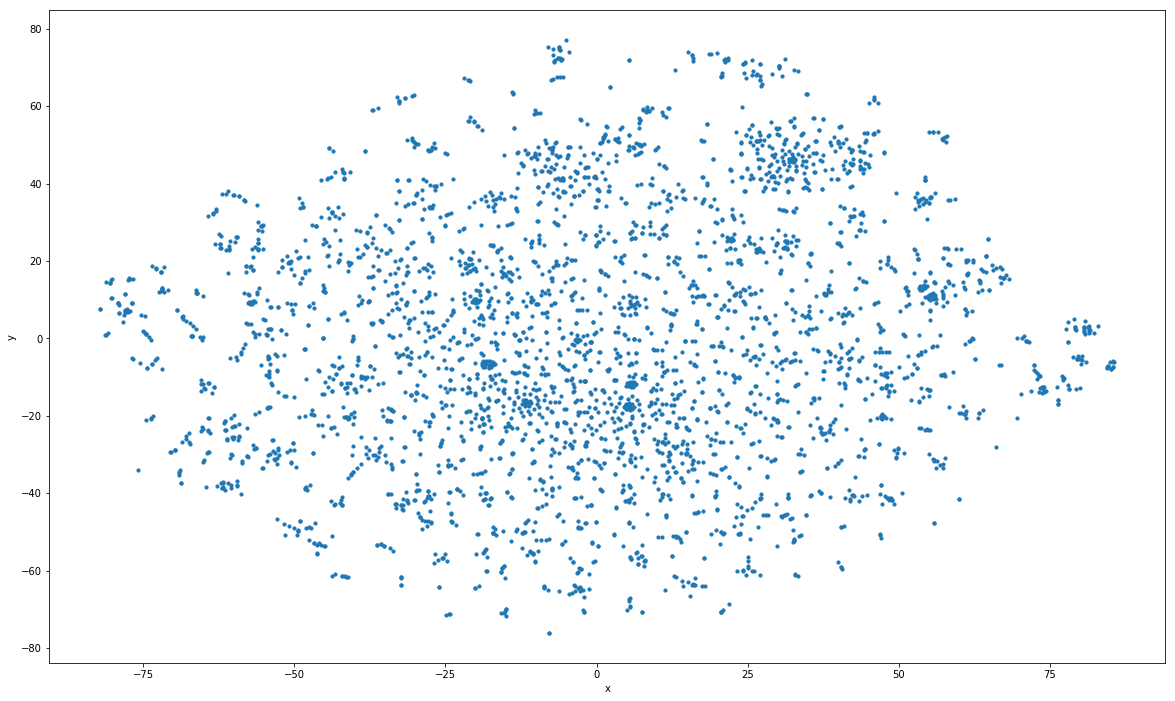

In [84]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [89]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

In [90]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

ValueError: scatter requires x column to be numeric

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

In [ ]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [34]:
thrones2vec.most_similar("Stark")

[(u'Eddard', 0.742438018321991),
 (u'Winterfell', 0.64848792552948),
 (u'Brandon', 0.6438549757003784),
 (u'Lyanna', 0.6438394784927368),
 (u'Robb', 0.6242259740829468),
 (u'executed', 0.6220564842224121),
 (u'Arryn', 0.6189971566200256),
 (u'Benjen', 0.6188897490501404),
 (u'direwolf', 0.614366352558136),
 (u'beheaded', 0.6046538352966309)]

In [35]:
thrones2vec.most_similar("Aerys")

[(u'Jaehaerys', 0.7991689443588257),
 (u'Daeron', 0.7808291912078857),
 (u'II', 0.7649893164634705),
 (u'reign', 0.7466063499450684),
 (u'Mad', 0.7380156517028809),
 (u'Beggar', 0.7334001660346985),
 (u'Rhaegar', 0.7308052182197571),
 (u'Unworthy', 0.7120681405067444),
 (u'Cruel', 0.7089171409606934),
 (u'Dome', 0.7070454359054565)]

In [36]:
thrones2vec.most_similar("direwolf")

[(u'Rickon', 0.6617892980575562),
 (u'SHAGGYDOG', 0.643834114074707),
 (u'wolf', 0.6403605341911316),
 (u'GHOST', 0.6385751962661743),
 (u'pup', 0.6156360507011414),
 (u'Robb', 0.6147520542144775),
 (u'Stark', 0.614366352558136),
 (u'crannogman', 0.6082616448402405),
 (u'wight', 0.606614351272583),
 (u'RICKON', 0.6039268970489502)]

**Linear relationships between word pairs**

In [37]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [38]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as Tyrion is related to wine
Arya is related to Nymeria, as Dany is related to dragons


u'Dany'